In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

In [2]:
inp_path = './CK+48/'

for dir_ in os.listdir(inp_path):
    count = 0
    for f in os.listdir(inp_path + dir_ + "/"):
        count+=1
    print(f"{dir_} folder has {count} number of images")

happy folder has 207 number of images
fear folder has 75 number of images
surprise folder has 249 number of images
sadness folder has 84 number of images
anger folder has 135 number of images


In [3]:
emotions = {"anger","happy","fear","sadness","surprise"}

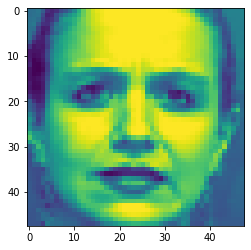

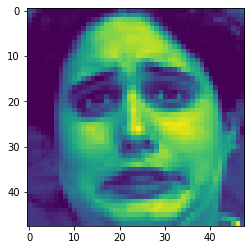

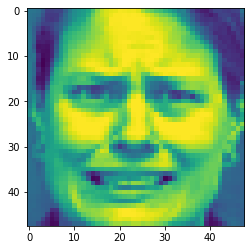

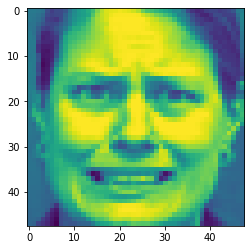

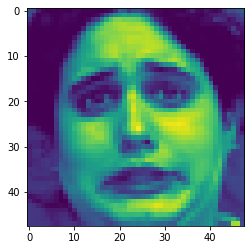

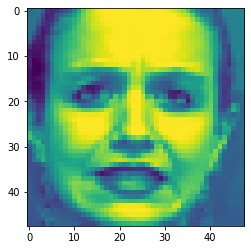

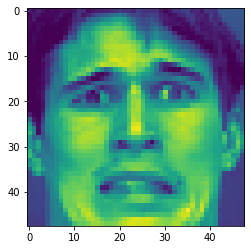

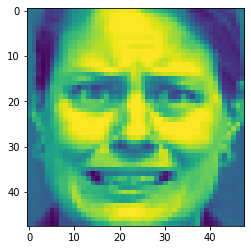

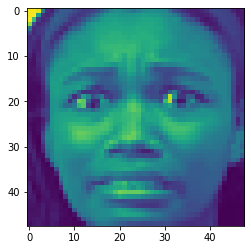

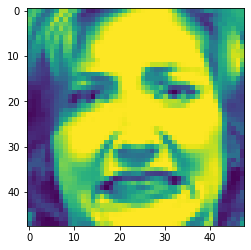

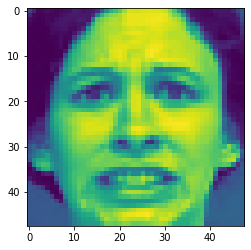

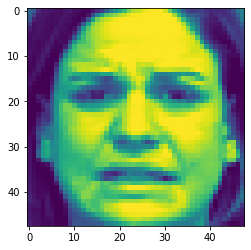

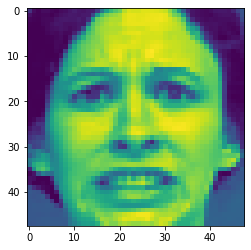

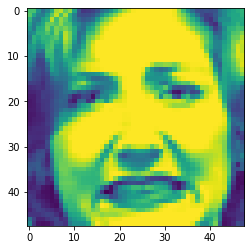

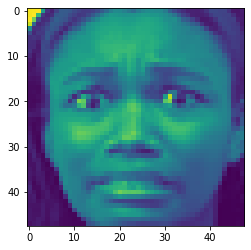

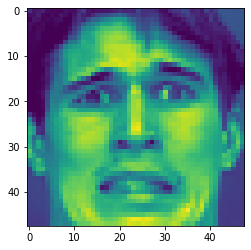

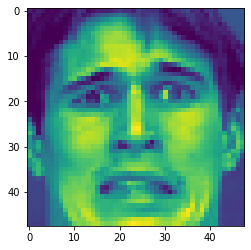

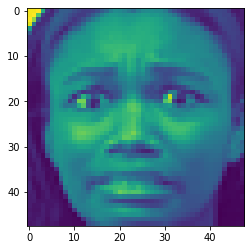

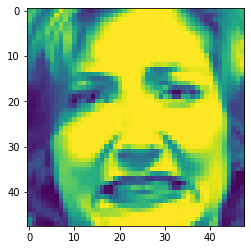

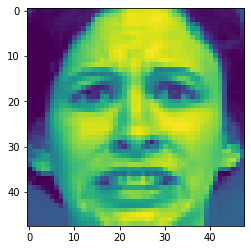

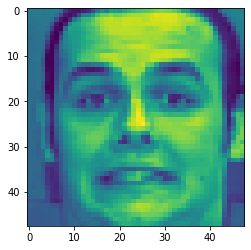

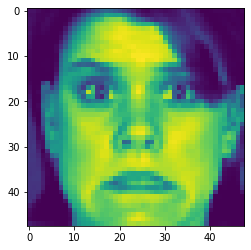

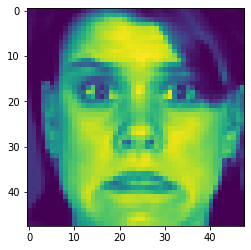

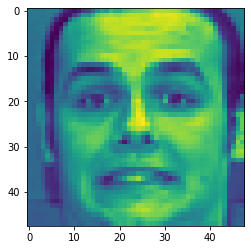

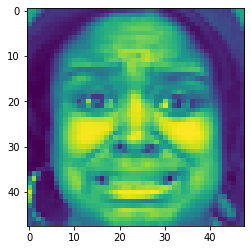

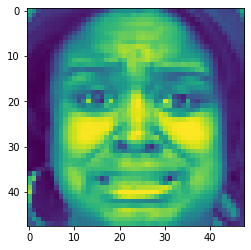

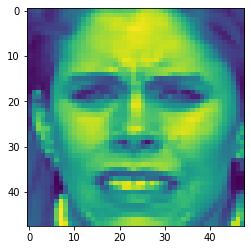

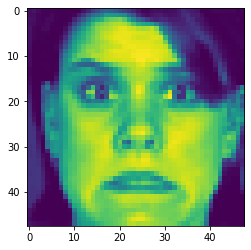

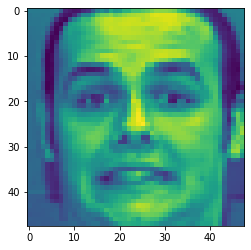

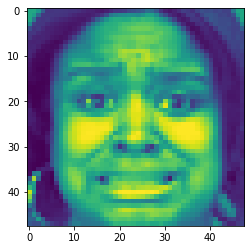

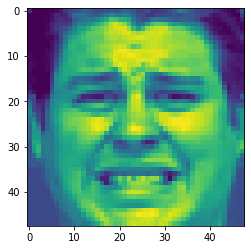

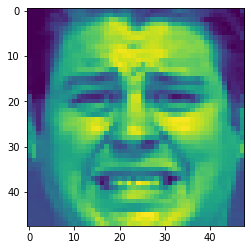

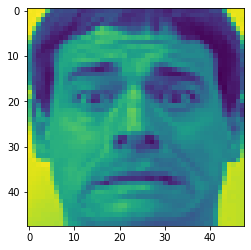

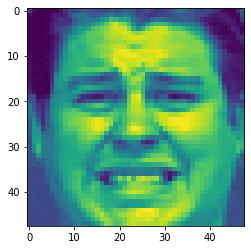

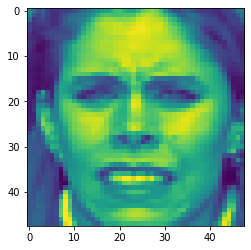

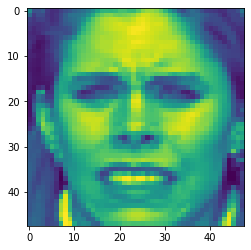

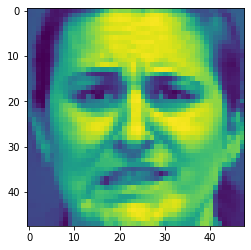

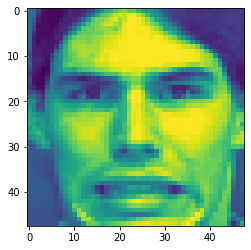

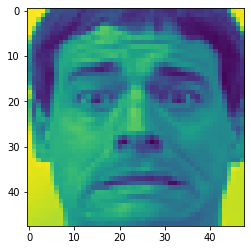

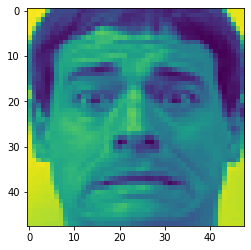

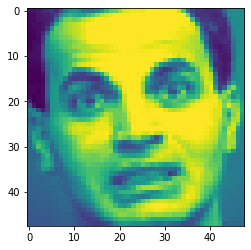

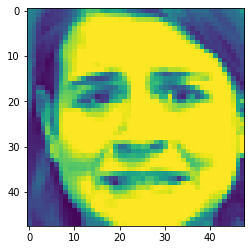

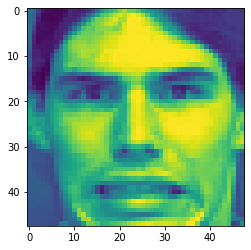

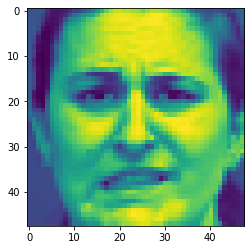

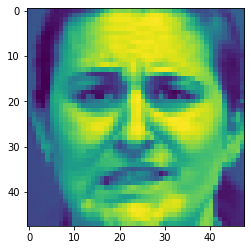

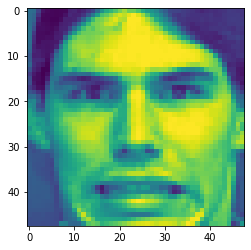

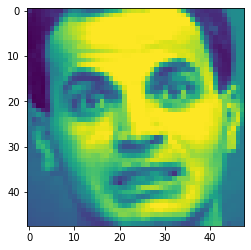

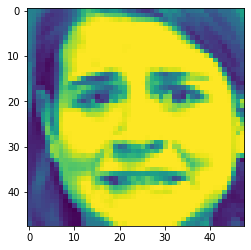

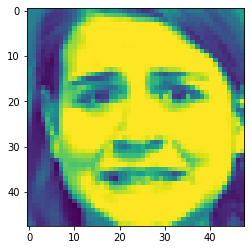

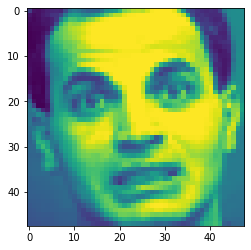

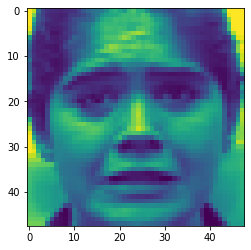

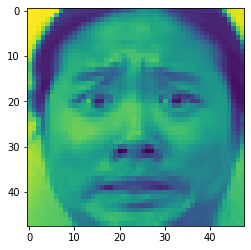

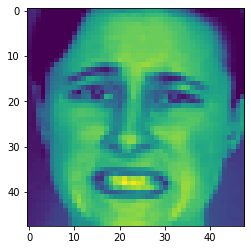

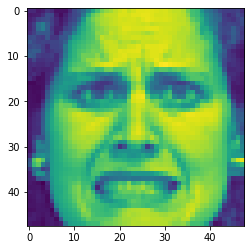

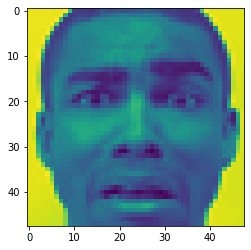

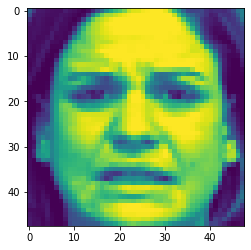

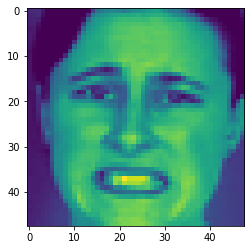

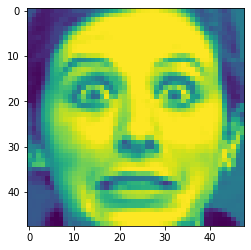

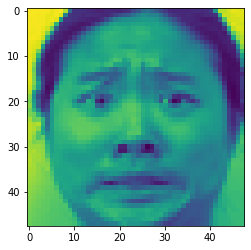

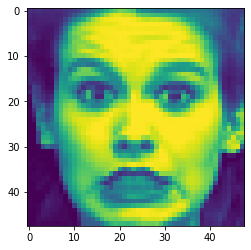

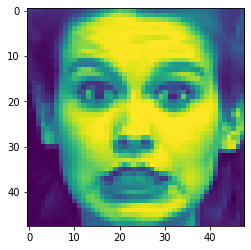

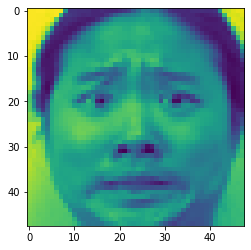

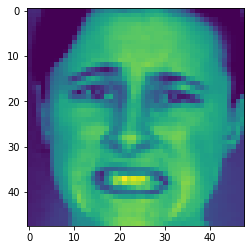

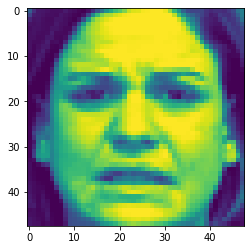

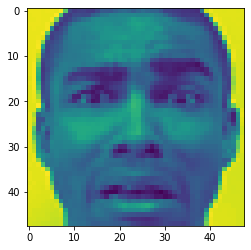

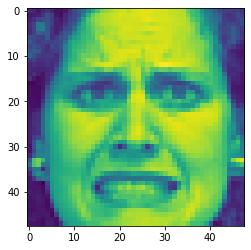

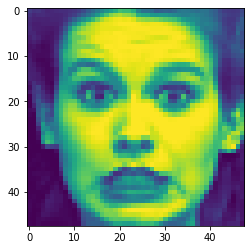

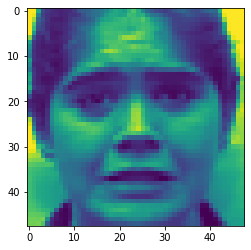

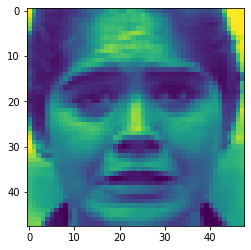

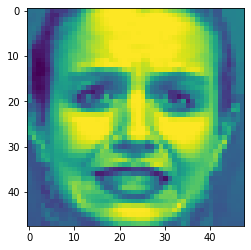

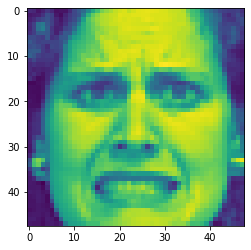

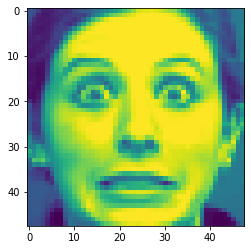

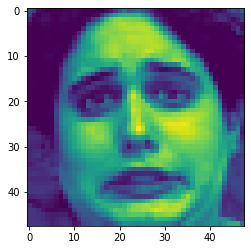

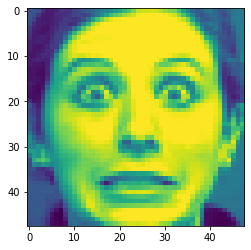

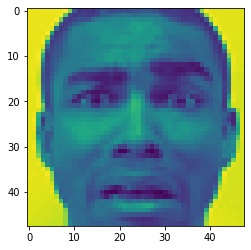

In [4]:
inp_path = './CK+48/'
path = inp_path + "fear" + "/"
for f in os.listdir(path):
    im = plt.imread(path+f)
    plt.imshow(im)
    plt.show()

### Removing duplicates from dataset

In [5]:
from collections import defaultdict

data = defaultdict(str)

In [6]:
for dir_ in os.listdir(inp_path):
    if dir_ in emotions:
        data[dir_] = defaultdict(list)
        for f in os.listdir(inp_path + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

In [7]:
for i in emotions:
    cnt = len(data[i])
    print(f"{i} has {cnt} number of images")

happy has 69 number of images
sadness has 28 number of images
anger has 45 number of images
surprise has 83 number of images
fear has 25 number of images


In [8]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Processing images into array form

In [9]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [10]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=inp_path + emotion + "/")) for k, v in data[emotion].items())

### Making a data of all images of emotions in separate array

In [11]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

X.shape, y.shape

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((250, 3, 48, 48, 1), (250, 5))

### Combining all 5 array 3 times

In [12]:
X1 = np.concatenate((surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear))
y1 = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y1 = np_utils.to_categorical(y1)

In [13]:
print(X1.shape)
print(y1.shape)

(750, 3, 48, 48, 1)
(750, 5)


In [14]:
emotion_map = {0:"surprise",1:"happy",2:"anger",3:"sadness",4:"fear"}

### Using Conv2D layers 

In [15]:
from keras.models import Sequential
from keras.layers import *
import tensorflow

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, train_size=0.7, stratify=y1, shuffle=True, random_state=42)
X_train.shape, X_valid.shape

((525, 3, 48, 48, 1), (225, 3, 48, 48, 1))

In [17]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [18]:
def build_convlstm(input_shape, num_class, show_summary=True):
    net = Sequential(name='ConvLSTM2D')

    net.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_1'
        )
    )
    net.add(Dropout(0.3, name='dropout_1'))

    net.add(
        ConvLSTM2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        ConvLSTM2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_2'
        )
    )
    net.add(Dropout(0.3, name='dropout_2'))

    net.add(
        ConvLSTM2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        ConvLSTM2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_3'
        )
    )
    net.add(Dropout(0.3, name='dropout_3'))
    
    net.add(TimeDistributed(Flatten(name="flatten")))
    
    net.add(
        TimeDistributed(
            Dense(
                64,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
            )
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(.6, name="dropout_4"))

    net.add(
        TimeDistributed(
            Dense(
                num_class,
                activation='softmax',
                name='out_layer'
            )
        )
    )

    if show_summary:
        net.summary()

    return net

In [19]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional, ConvLSTM2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


In [20]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_convlstm(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "ConvLSTM2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convlstm2d_1 (ConvLSTM2D)    (None, 3, 48, 48, 64)     150016    
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 3, 48, 48, 64)     256       
_________________________________________________________________
convlstm2d_2 (ConvLSTM2D)    (None, 3, 48, 48, 64)     295168    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 3, 48, 48, 64)     256       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 3, 24, 24, 64)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 24, 24, 64)     0         
_________________________________________

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.7,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 64
epochs = 10

In [22]:
y_train_ = np.empty((y_train.shape[0], 3, 5))
for i in range(y_train.shape[0]):
    y_train_[i] = np.tile(y_train[i], (3,1))
    
y_valid_ = np.empty((y_valid.shape[0], 3, 5))
for i in range(y_valid.shape[0]):
    y_valid_[i] = np.tile(y_valid[i], (3,1))

In [23]:
history = model.fit(
    x=X_train,
    y=y_train_,
    validation_data=(X_valid, y_valid_),
    batch_size=batch_size,
    epochs=20,
    callbacks=callbacks,
    use_multiprocessing=True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 525 samples, validate on 225 samples
Epoch 1/20
525/525 [==============================] - 562s 1s/sample - loss: 1.8521 - acc: 0.4387 - val_loss: 1.5703 - val_acc: 0.3333
Epoch 2/20
525/525 [==============================] - 553s 1s/sample - loss: 0.6775 - acc: 0.7422 - val_loss: 1.5613 - val_acc: 0.3333
Epoch 3/20
525/525 [==============================] - 557s 1s/sample - loss: 0.4481 - acc: 0.8457 - val_loss: 1.6120 - val_acc: 0.3333
Epoch 4/20
525/525 [==============================] - 662s 1s/sample - loss: 0.3520 - acc: 0.8775 - val_loss: 1.6624 - val_acc: 0.3333
Epoch 5/20
128/525 [======>.......................] - ETA: 8:00 - loss: 0.1950 - acc: 0.9531

KeyboardInterrupt: 

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(3,48,48,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(3,48,48,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(3,48,48,1)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
hist = model.fit(X_train,y_train,epochs=20,shuffle=True,batch_size=32,validation_split=0.10)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(48,48))
    img = image.img_to_array(img)
    
    img = img.reshape((1,48,48,3))
    
    # normalization (using resnet50 function)
    img = preprocess_input(img)
    
    return img